# Проект: Обучение с учителем: качество модели
### Описание проекта:
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений. «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
### Цель проекта:
Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
### Ход исследования:
Шаг 1. Загрузка и изучение данных
Шаг 2. Предобработка данных
Шаг 3. Исследовательский анализ данных
Шаг 4. Объединение таблиц
Шаг 5. Корреляционный анализ
Шаг 6. Использование Пайплайнов
Шаг 7. Анализ важности признаков
Шаг 8. Сегмегтация покупателей
Шаг 9. Общий вывод

In [1]:
pip install phik -q 

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install scikit-learn==1.5.2 -q

In [3]:
!pip install shap -q

## Шаг 1.Загрузка данных:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import shap

In [5]:
market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
display(market_file.head(5))

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
display(market_money.head(5))

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
display(market_time.head(5))

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')
display(money.head(5))

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Вывод: Мы импортировали все нужные библиотеки и загрузили 4 файла с данными. Данные в таблицах соответствуют описанию.

## Шаг 2. Предобработка данных

### Проверка типов значений в каждом столбце:

In [9]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [10]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [11]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [12]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


В каждой таблице все значения находятся в нужном типе

### Обработка пропусков:

In [13]:
def check_missing_values(df):
    for column in df.columns:
        missing_values_count = df[column].isnull().sum()
        print(f"Столбец '{column}': {missing_values_count} пропусков")

In [14]:
check_missing_values(market_file)

Столбец 'id': 0 пропусков
Столбец 'Покупательская активность': 0 пропусков
Столбец 'Тип сервиса': 0 пропусков
Столбец 'Разрешить сообщать': 0 пропусков
Столбец 'Маркет_актив_6_мес': 0 пропусков
Столбец 'Маркет_актив_тек_мес': 0 пропусков
Столбец 'Длительность': 0 пропусков
Столбец 'Акционные_покупки': 0 пропусков
Столбец 'Популярная_категория': 0 пропусков
Столбец 'Средний_просмотр_категорий_за_визит': 0 пропусков
Столбец 'Неоплаченные_продукты_штук_квартал': 0 пропусков
Столбец 'Ошибка_сервиса': 0 пропусков
Столбец 'Страниц_за_визит': 0 пропусков


In [15]:
check_missing_values(market_money)

Столбец 'id': 0 пропусков
Столбец 'Период': 0 пропусков
Столбец 'Выручка': 0 пропусков


In [16]:
check_missing_values(market_time)

Столбец 'id': 0 пропусков
Столбец 'Период': 0 пропусков
Столбец 'минут': 0 пропусков


In [17]:
check_missing_values(money)

Столбец 'id': 0 пропусков
Столбец 'Прибыль': 0 пропусков


Пропусков нет

### Проврека явных и неявных дубликатов:

In [18]:
print(market_file.duplicated().sum())
print(market_money.duplicated().sum())
print(market_time.duplicated().sum())
print(money.duplicated().sum())

0
0
0
0


Явных дубликатов нет, проведем проверку на неявные дубликаты

In [19]:
for column in market_file.columns:
    if market_file[column].dtype == 'object':
        print(f'Для столбца {column} уникальные значения: {market_file[column].unique()}')

Для столбца Покупательская активность уникальные значения: ['Снизилась' 'Прежний уровень']
Для столбца Тип сервиса уникальные значения: ['премиум' 'стандартт' 'стандарт']
Для столбца Разрешить сообщать уникальные значения: ['да' 'нет']
Для столбца Популярная_категория уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [20]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [21]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Заметим, что в market_file в столбце Тип сервиса есть неявный дубликат, а в столбце Период таблицы market_time есть опечтака, исправим это

In [22]:
market_file['Тип сервиса'].replace('стандартт', 'стандарт', inplace = True)
market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace = True)

Вывод:Была проведена предобработка данных. Типы данных оказались корректными, пропусков не найдено, а вот дубликаты были найдены и исправленны.

## Шаг 3. Исследовательский анализ данных

In [23]:
def visualize_dataframe(dataframe):
    for column in dataframe.columns:
        column_type = dataframe[column].dtype

        if column_type == 'object':
            value_counts = dataframe[column].value_counts()
            value_counts.plot.pie(autopct='%1.1f%%', startangle=90)
            plt.title(f'{column} - Круговая диаграмма')
            plt.show()

        elif column_type in ['int64', 'float64'] and column != 'id':
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
            if column in ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'минут']:
                sns.countplot(x=column, ax=axes[0], data=dataframe)
                axes[0].set_title(f'{column} - Столбчатая диаграмма')
                axes[0].set_xlabel(column)
                axes[0].set_ylabel('Частота')
            else:
                dataframe[column].plot.hist(bins=25, ax=axes[0])
                axes[0].set_title(f'{column} - Гистограмма')
                axes[0].set_xlabel(column)
                axes[0].set_ylabel('Частота')
            sns.boxplot(x=dataframe[column], ax=axes[1])
            axes[1].set_title(f'{column} - Boxplot')
            axes[1].set_xlabel(column)

            plt.show()
            
            print(dataframe[column].describe())

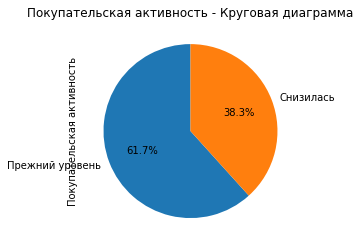

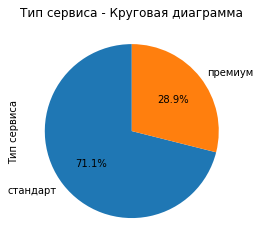

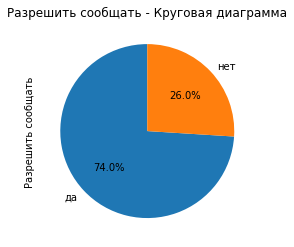

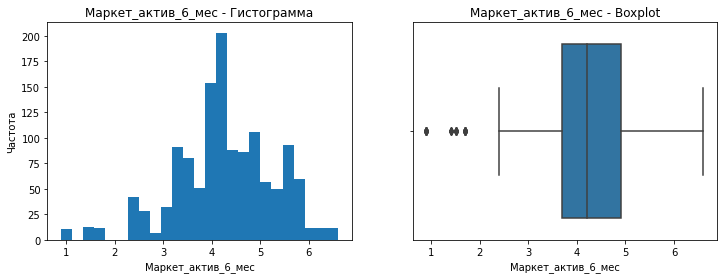

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64


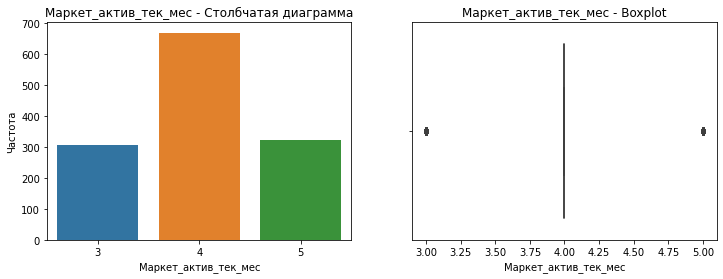

count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64


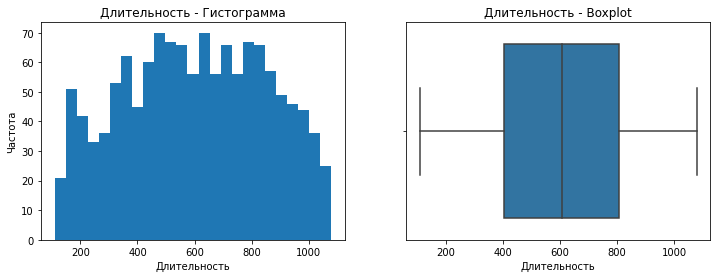

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64


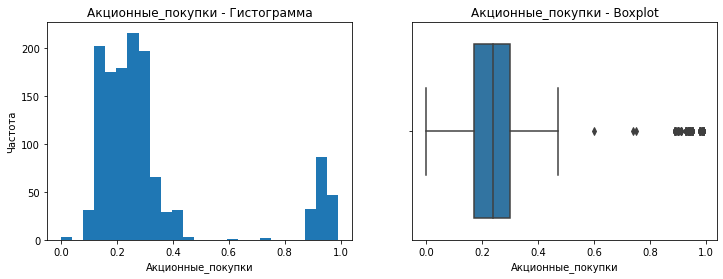

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64


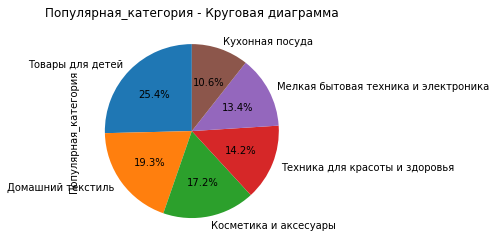

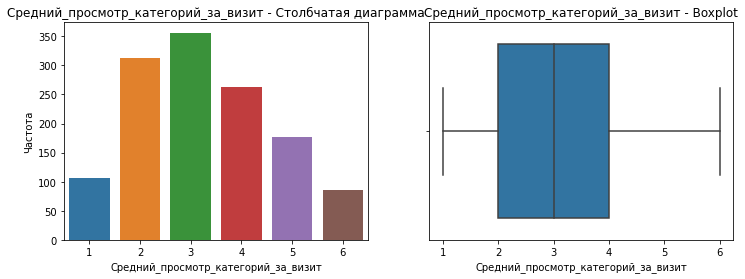

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


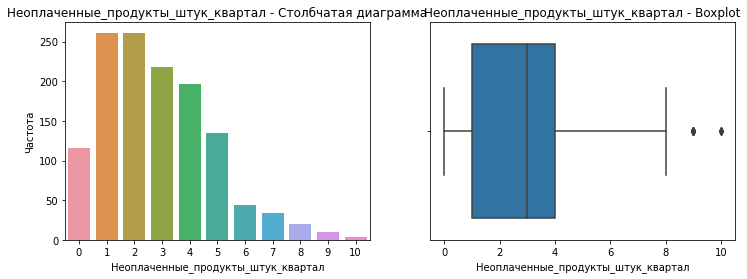

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


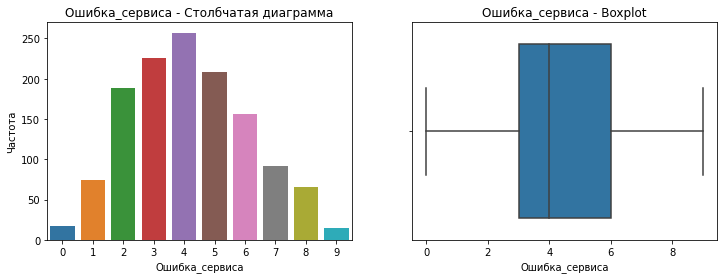

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64


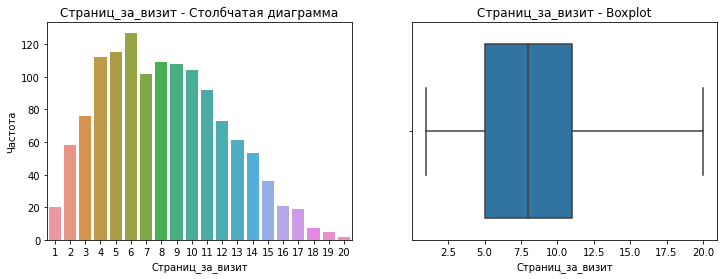

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64


In [24]:
visualize_dataframe(market_file)

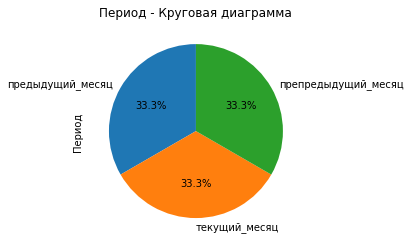

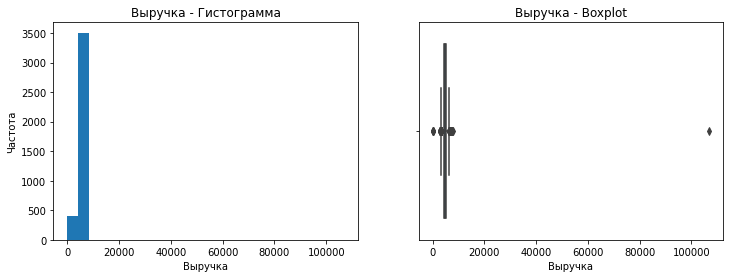

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64


In [25]:
visualize_dataframe(market_money)

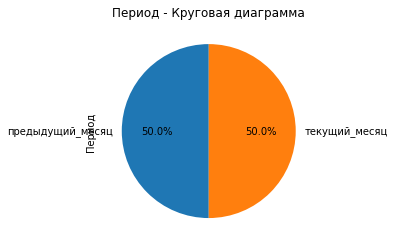

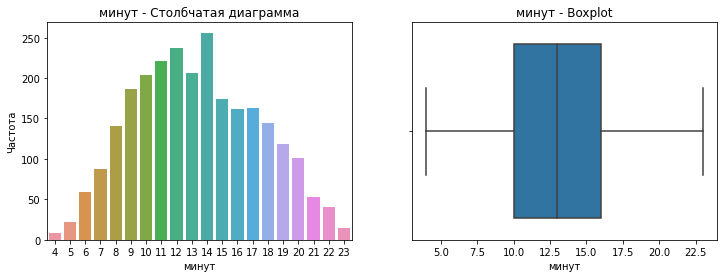

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64


In [26]:
visualize_dataframe(market_time)

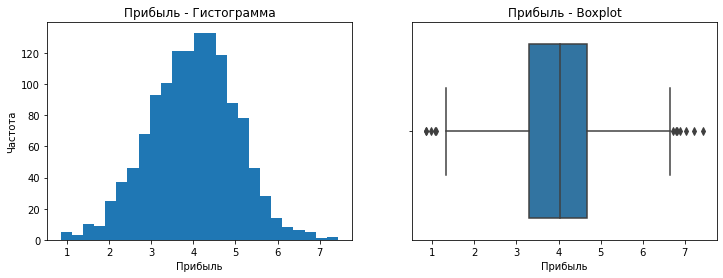

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64


In [27]:
visualize_dataframe(money)

В датафреймах money, market_time и market_filr выбросов я не обнаружил. Зато в датафрейме market_money в столбце выручка мы видим явный выброс. Так как мы не сможем заменить это одно значение на какое-либо другое, удалим все строки с таким id, при котором случаетсявыброс в датафрейме market_money

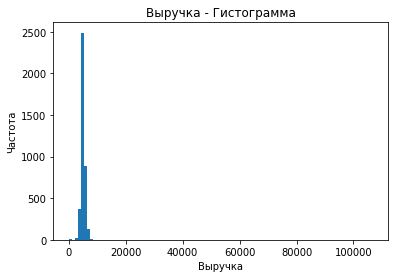

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64


In [28]:
market_money['Выручка'].plot.hist(bins = 100)
plt.title(f'Выручка - Гистограмма')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()
            
print(market_money['Выручка'].describe())

In [29]:
market_money.shape

(3900, 3)

In [30]:
id_to_drop = market_money[market_money['Выручка'] == 106862.2]['id']

market_money = market_money[~market_money['id'].isin(id_to_drop)]
money = money[~money['id'].isin(id_to_drop)]
market_time = market_time[~market_time['id'].isin(id_to_drop)]
market_file = market_file[~market_file['id'].isin(id_to_drop)]

In [31]:
market_money.shape

(3897, 3)

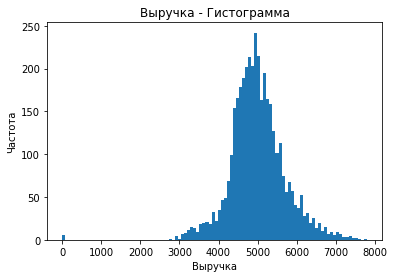

count    3897.000000
mean     4999.287760
std       706.970089
min         0.000000
25%      4590.000000
50%      4956.000000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64


In [32]:
market_money['Выручка'].plot.hist(bins = 100)
plt.title(f'Выручка - Гистограмма')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()
            
print(market_money['Выручка'].describe())

Вывод:Был проведён исследовательский анализ данных. Мы нашли всего лишь один выброс, который сразу удалили.

## Шаг 4. Объединение таблиц

### Объедините таблицы market file.csv, market money.csv, market time.csv:

Для начала приведем каждую таблицу к одинаковому количеству столбцов

In [33]:
market_file.shape

(1299, 13)

In [34]:
market_file.set_index('id', inplace=True)
market_file.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
id,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [35]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [36]:
market_money = market_money.pivot_table(index='id', columns='Период', values='Выручка')
market_money.columns = ['выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц']
market_money.head()

,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [37]:
market_money.shape

(1299, 3)

In [38]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [39]:
market_time = market_time.pivot_table(index='id', columns='Период', values='минут')
market_time.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
print(market_time.head())

        минут_предыдущий_месяц  минут_текущий_месяц
id                                                 
215348                      13                   14
215349                      12                   10
215350                       8                   13
215351                      11                   13
215352                       8                   11


In [40]:
market_time.shape

(1299, 2)

Для обучения столбец id не нужен, поэтому сделаем эти значения индексами с помощью set_index(). Метод не меняет таблицу, а возвращает новую, поэтому переменную нужно перезаписать:

In [41]:
market_full = market_file.join(market_money, how = 'inner')
market_full = market_full.join(market_time, how = 'inner')
market_full.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_препредыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [42]:
market_full.shape

(1299, 17)

In [43]:
without_purchase_df = market_full[(market_full['выручка_препредыдущий_месяц'] == 0) | 
                          (market_full['выручка_текущий_месяц'] == 0) | 
                          (market_full['выручка_предыдущий_месяц'] == 0)]
print(without_purchase_df.shape)

(3, 17)


In [44]:
market_full = market_full.drop(index=without_purchase_df.index)

print(market_full.shape)

(1296, 17)


Таблица была объединена по всем требованиям.

## Шаг 5. Корреляционный анализ

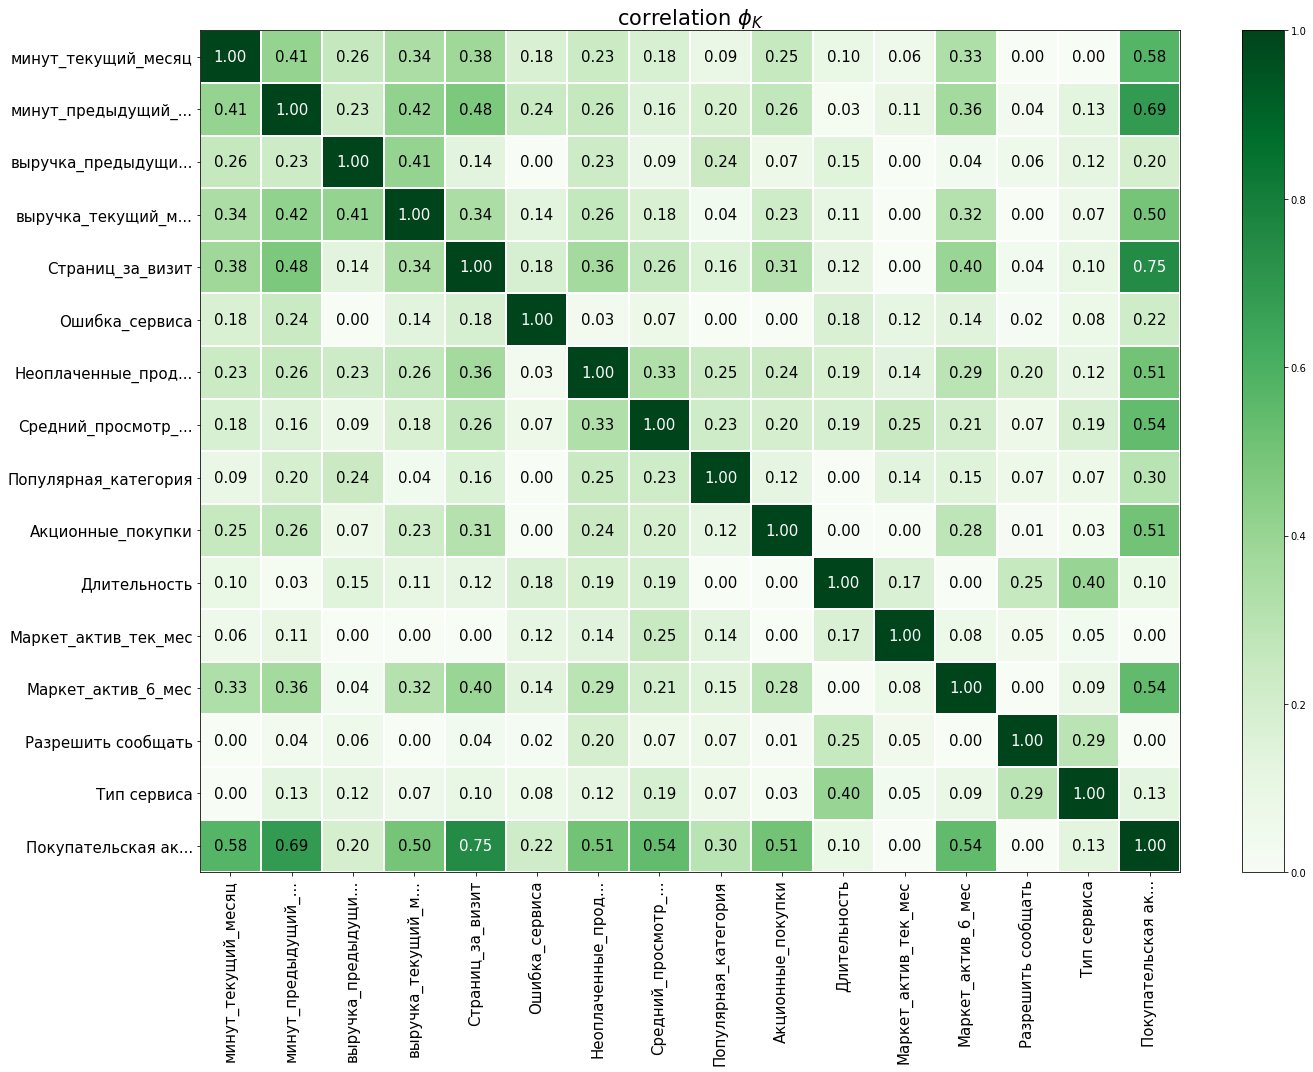

In [57]:
interval_cols = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
phik_overview = phik_matrix(market_full, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)


Мультиколлинераность не обнаружена

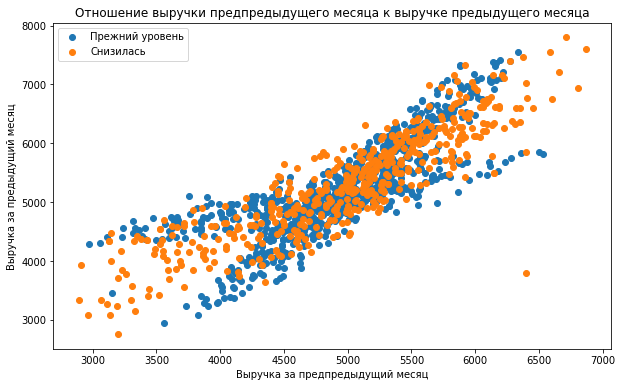

In [46]:
plt.figure(figsize=(10, 6))
for activity, group in market_full.groupby('Покупательская активность'):
    plt.scatter(group['выручка_препредыдущий_месяц'], group['выручка_предыдущий_месяц'], label=activity)
plt.xlabel('Выручка за предпредыдущий месяц')
plt.ylabel('Выручка за предыдущий месяц')
plt.title('Отношение выручки предпредыдущего месяца к выручке предыдущего месяца')
plt.legend()
plt.show()

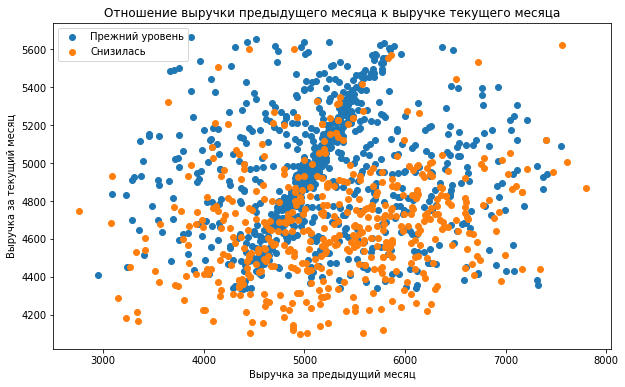

In [47]:
plt.figure(figsize=(10, 6))
for activity, group in market_full.groupby('Покупательская активность'):
    plt.scatter(group['выручка_предыдущий_месяц'], group['выручка_текущий_месяц'], label=activity)
plt.xlabel('Выручка за предыдущий месяц')
plt.ylabel('Выручка за текущий месяц')
plt.title('Отношение выручки предыдущего месяца к выручке текущего месяца')
plt.legend()
plt.show()

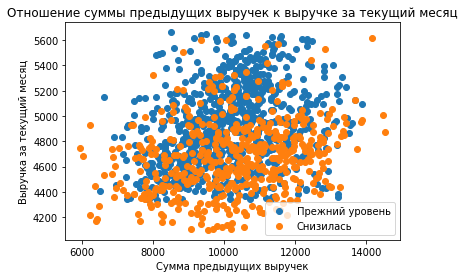

In [48]:
for activity, group in market_full.groupby('Покупательская активность'):
    plt.scatter(group['выручка_препредыдущий_месяц'] + group['выручка_предыдущий_месяц'], 
                group['выручка_текущий_месяц'], 
                label=activity)

plt.xlabel('Сумма предыдущих выручек')
plt.ylabel('Выручка за текущий месяц')
plt.title('Отношение суммы предыдущих выручек к выручке за текущий месяц')

plt.legend()

plt.show()


In [49]:
market_full.drop(columns=['выручка_препредыдущий_месяц'], inplace=True)

Вывод: По итогом корреляционого анализа была обнаружена мультиколлинеарность, которую мы сразу устранили.

## Шаг 6. Использование пайплайнов

In [50]:
label_encoder = LabelEncoder()
label_encoder.fit(market_full['Покупательская активность'])
market_full['Покупательская активность'] = label_encoder.transform(market_full['Покупательская активность'])
market_full['Покупательская активность'].unique()

array([1, 0])

In [51]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   int64  
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит       

### Во время подготовки данных используем ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков используем два кодировщика, для масштабирования количественных — два скейлера.

In [52]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    market_full.drop(
        [
             'Покупательская активность'
        ], 
        axis=1
    ),
    market_full['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_full['Покупательская активность']
)

# создаём списки с названиями признаков
ohe_columns = [
    'Разрешить сообщать', 'Популярная_категория'
]
ord_columns = [
    'Тип сервиса', 
]
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
                      'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
                      'Ошибка_сервиса', 'Страниц_за_визит',
                      'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'минут_предыдущий_месяц',
                      'минут_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),  # Пайплайн для категориальных признаков
        ('ord', ord_pipe, ord_columns),  # Пайплайн для порядковых признаков
        ('num', MinMaxScaler(), num_columns) 
    ], 
    remainder='passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Разрешить сообщать',
                                  'Популярная_категория']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_f...
                                                  SimpleImputer(strategy='most_frequent'))]),
                             

### Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подберем как минимум один гиперпараметр. Для задачи будем использовать метрику roc_auc. ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного.

In [53]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],  # Установите probability=True для использования predict_proba
        'models__C': [0.1, 1, 10],  # Список значений параметра C
        'models__kernel': ['linear', 'rbf'],  # Список ядер
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели по кросс валидации:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred_proba = randomized_search.predict_proba(X_test)

# Взять в качестве предсказания класс с наибольшей вероятностью
y_test_pred = y_test_pred_proba[:, 1]

# Рассчитать ROC-AUC на тестовой выборке
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                 

Лучшей моделью оказалась SVC

## Шаг 7.Анализ важности признаков

In [54]:
RANDOM_STATE = 97
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(
    market_full.drop(['Покупательская активность'], axis=1),
    market_full['Покупательская активность'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=market_full['Покупательская активность']
)

# Создание списка колонок для обработки
ohe_columns = ['Разрешить сообщать', 'Популярная_категория']
ord_columns = ['Тип сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки',
               'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
               'Ошибка_сервиса', 'Страниц_за_визит', 
               'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'минут_предыдущий_месяц',
               'минут_текущий_месяц']

# Обработка категориальных признаков
ohe_imputer = SimpleImputer(strategy='most_frequent')
X_train_ohe = ohe_imputer.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_imputer.transform(X_test[ohe_columns])

ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_ohe_encoded = ohe_encoder.fit_transform(X_train_ohe)
X_test_ohe_encoded = ohe_encoder.transform(X_test_ohe)

# Обработка порядковых признаков
ord_imputer = SimpleImputer(strategy='most_frequent')
X_train_ord = ord_imputer.fit_transform(X_train[ord_columns])
X_test_ord = ord_imputer.transform(X_test[ord_columns])

ord_encoder = OrdinalEncoder(categories=[['премиум', 'стандарт']], handle_unknown='use_encoded_value', unknown_value=np.nan)
X_train_ord_encoded = ord_encoder.fit_transform(X_train_ord)
X_test_ord_encoded = ord_encoder.transform(X_test_ord)

# Обработка числовых признаков
num_scaler = MinMaxScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train[num_columns])
X_test_num_scaled = num_scaler.transform(X_test[num_columns])

X_train_processed = np.hstack((X_train_ohe_encoded, X_train_ord_encoded, X_train_num_scaled, X_train.drop(ohe_columns + ord_columns + num_columns, axis=1)))
X_test_processed = np.hstack((X_test_ohe_encoded, X_test_ord_encoded, X_test_num_scaled, X_test.drop(ohe_columns + ord_columns + num_columns, axis=1)))
X_train_processed = pd.DataFrame(
    X_train_processed,
    columns=(
        list(ohe_encoder.get_feature_names_out(ohe_columns)) +
        ord_columns +
        num_columns +
        list(X_train.drop(ohe_columns + ord_columns + num_columns, axis=1).columns)
    )
)

# Создание DataFrame из X_test_processed
X_test_processed = pd.DataFrame(
    X_test_processed,
    columns=(
        list(ohe_encoder.get_feature_names_out(ohe_columns)) +
        ord_columns +
        num_columns +
        list(X_test.drop(ohe_columns + ord_columns + num_columns, axis=1).columns)
    )
)
# Обучение модели SVC с лучшими параметрами
best_svc_model = SVC(C=1, probability=True, random_state=RANDOM_STATE)
best_svc_model.fit(X_train_processed, y_train)

# Получение предсказаний и метрики на тестовой выборке
y_test_pred_proba = best_svc_model.predict_proba(X_test_processed)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print('Метрика ROC-AUC на тестовой выборке:', roc_auc)

Метрика ROC-AUC на тестовой выборке: 0.8986368968167294


In [ ]:
best_model = randomized_search.best_estimator_.named_steps['models']

preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

X_train_processed = preprocessor.transform(X_train)

explainer = shap.Explainer(best_model.predict_proba, X_train_processed) 

shap_values = explainer(X_train_processed)
shap.plots.beeswarm(shap_values[:,:,1], max_display=13)
shap.plots.waterfall(shap_values[0, :, 1], max_display=16) 
shap.plots.bar(shap_values[:,:,1], max_display=16)

Последний график показывает показывает общую значимость признаков, здесь лидирует признак 'Страниц за визит', дальше идут такие признаки как 'минут_предыдущий_месяц' и 'Акционные_покупки'. Признаки на графике расположены в порядке убывания их вклада: если убрать те, что наверху, качество модели просядет сильнее всего.

Теперь обратим внимание на график, который мы построили первым, он показывает как признаки влияют на предсказание модели. Высокое значение параметров 'страниц за визит' и 'минут предыдущий месяц' снижает вероятность принадлежности Покупательской активности клиента к классу 'Прежний уровень', что объяснить логически давольно сложно. Зато третий по значимости признак интерпритируется логически просто, высокие значение параметра 'акционные покупки' повышает вероятность принадлжености Покупательской активности клинета к классу 'Прежний уровень'.

## Шаг 8.Сегментация покупателей

In [60]:
market_full.head(3)

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,4971.6,12,10
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5058.4,8,13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6610.4,11,13


In [61]:
money.head(3)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


In [62]:
money.set_index('id', inplace=True)
market_full = market_full.join(money, how = 'inner')
market_full.head(3)

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,4971.6,12,10,4.16
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5058.4,8,13,3.13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6610.4,11,13,4.87


Двумя самыми популярными категориями являются Товары для детей и домашний текстиль(см Шаг3. Исследовательский анализ данных), рассмотрим эти два сегмента покупателей, сравним их, сделаем выводы и предложим метроприятия, которые могут увеличить покупательную активность для пользователей в этих сегментах

In [63]:
market_tovary_dla_detei = market_full[market_full['Популярная_категория'] == 'Товары для детей']
market_tovary_dla_detei.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,4971.6,12,10,4.16
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6610.4,11,13,4.87
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5872.5,8,11,4.21
215355,1,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,4749.0,3772.6,12,10,5.26
215363,1,стандарт,нет,4.9,4,923,0.29,Товары для детей,6,0,3,1,4633.0,6128.3,8,5,1.83


In [64]:
market_domashniy_tekstil = market_full[market_full['Популярная_категория'] == 'Домашний текстиль']
market_domashniy_tekstil.head()

PermutationExplainer explainer:   2%|▏         | 16/972 [00:24<6:37:43, 24.96s/it]


,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_текущий_месяц,выручка_предыдущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,Прибыль
id,,,,,,,,,,,,,,,,,
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5058.4,8,13,3.13
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,5388.5,10,10,3.95
215358,1,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,4727.0,4209.5,14,10,3.06
215362,1,премиум,да,4.2,4,438,0.74,Домашний текстиль,3,4,6,4,4765.0,4447.9,13,13,3.49
215364,1,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,4942.0,5484.8,11,9,2.67


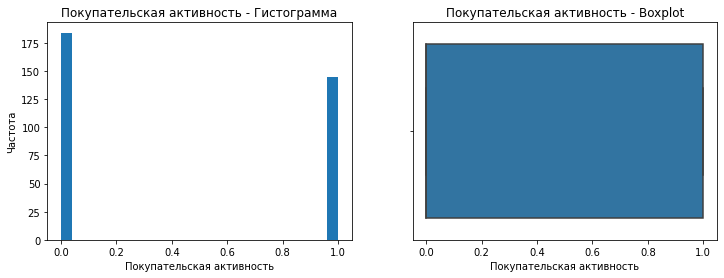

count    329.000000
mean       0.440729
std        0.497231
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Покупательская активность, dtype: float64


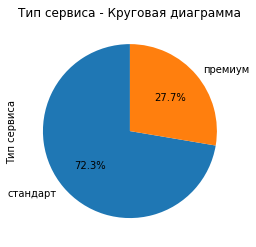

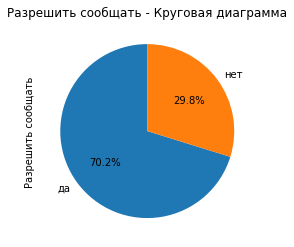

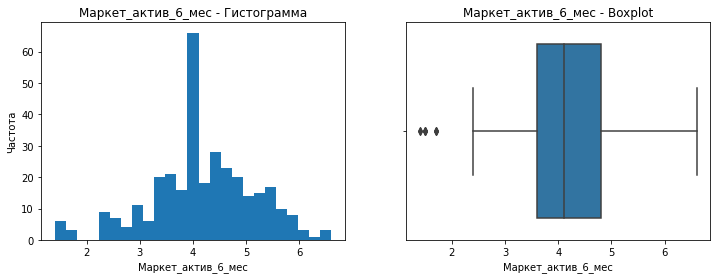

count    329.000000
mean       4.185106
std        0.983363
min        1.400000
25%        3.600000
50%        4.100000
75%        4.800000
max        6.600000
Name: Маркет_актив_6_мес, dtype: float64


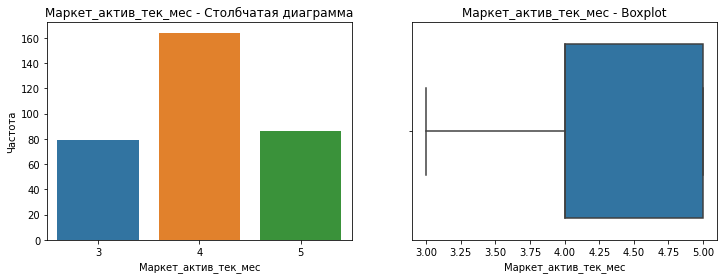

count    329.000000
mean       4.021277
std        0.708939
min        3.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Маркет_актив_тек_мес, dtype: float64


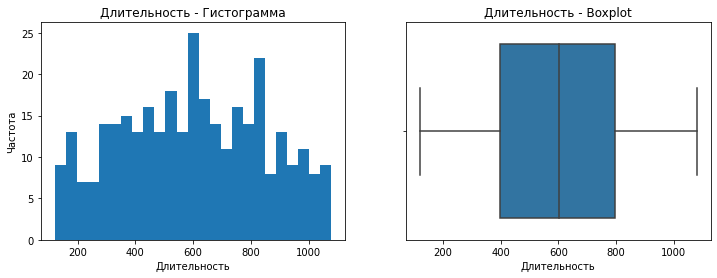

count     329.000000
mean      598.741641
std       250.400807
min       121.000000
25%       399.000000
50%       602.000000
75%       795.000000
max      1079.000000
Name: Длительность, dtype: float64


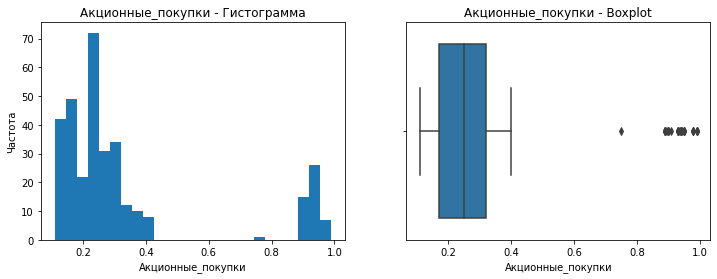

count    329.000000
mean       0.336353
std        0.257720
min        0.110000
25%        0.170000
50%        0.250000
75%        0.320000
max        0.990000
Name: Акционные_покупки, dtype: float64


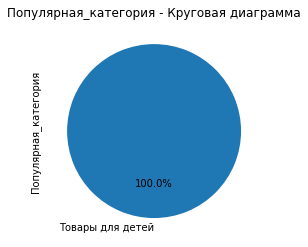

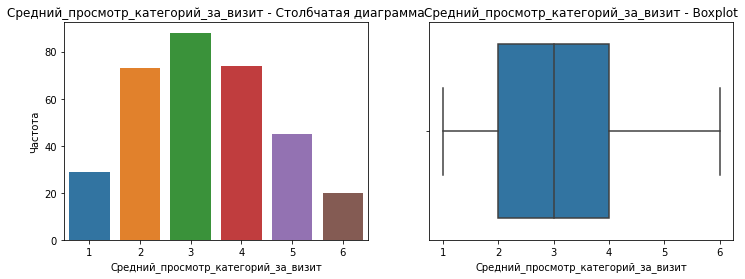

count    329.000000
mean       3.282675
std        1.348793
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


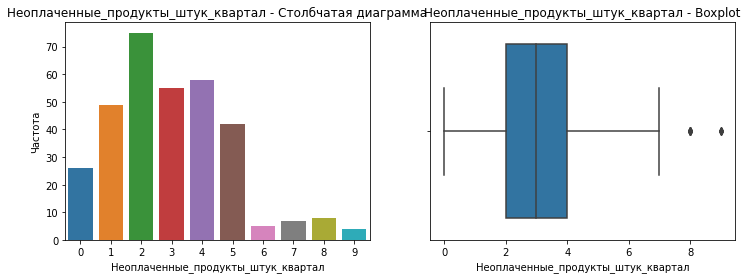

count    329.000000
mean       2.993921
std        1.938056
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


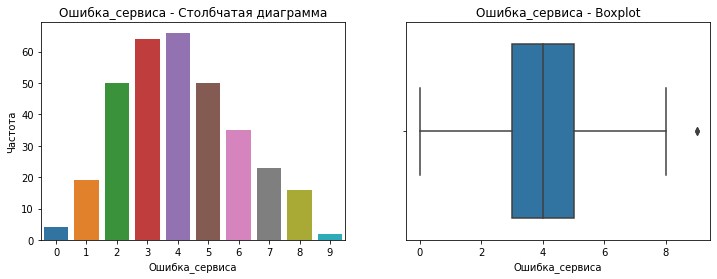

count    329.000000
mean       4.079027
std        1.912687
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        9.000000
Name: Ошибка_сервиса, dtype: float64


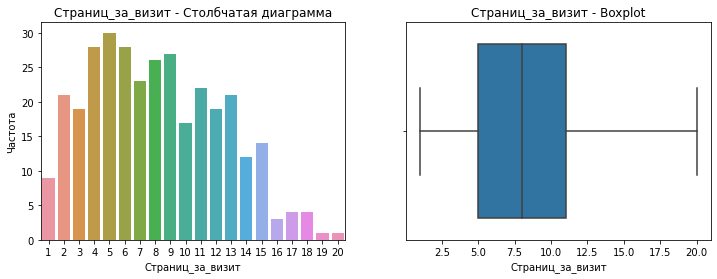

count    329.000000
mean       8.109422
std        4.256294
min        1.000000
25%        5.000000
50%        8.000000
75%       11.000000
max       20.000000
Name: Страниц_за_визит, dtype: float64


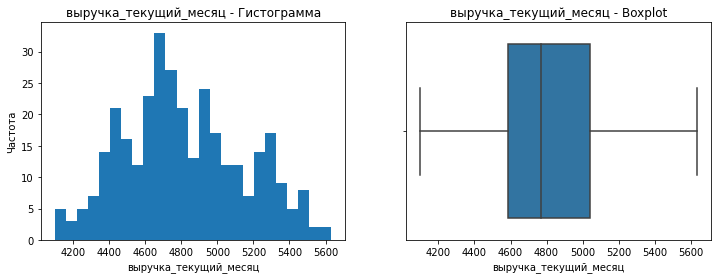

count     329.000000
mean     4816.960486
std       332.799556
min      4098.000000
25%      4586.000000
50%      4767.000000
75%      5039.000000
max      5633.000000
Name: выручка_текущий_месяц, dtype: float64


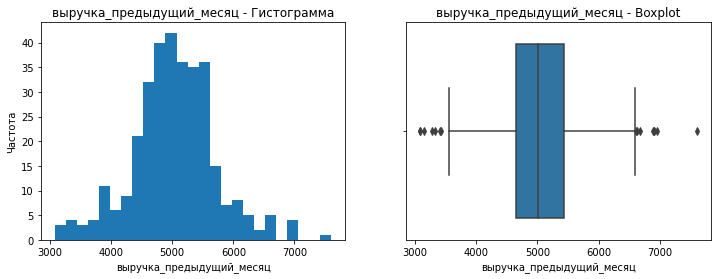

count     329.000000
mean     5027.852888
std       684.529478
min      3078.300000
25%      4651.000000
50%      5002.000000
75%      5433.600000
max      7605.300000
Name: выручка_предыдущий_месяц, dtype: float64


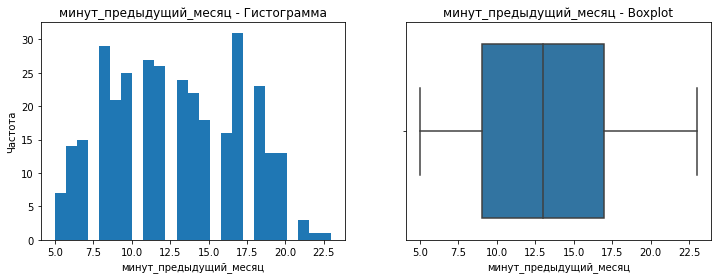

count    329.000000
mean      12.784195
std        4.228849
min        5.000000
25%        9.000000
50%       13.000000
75%       17.000000
max       23.000000
Name: минут_предыдущий_месяц, dtype: float64


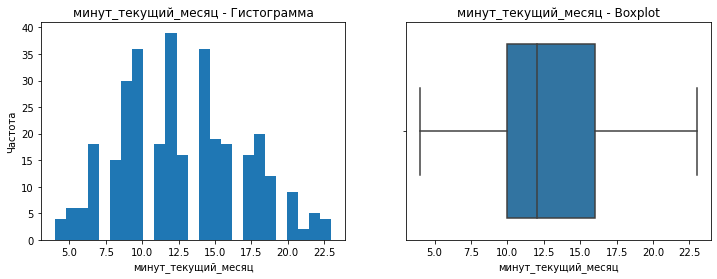

count    329.000000
mean      12.744681
std        4.188600
min        4.000000
25%       10.000000
50%       12.000000
75%       16.000000
max       23.000000
Name: минут_текущий_месяц, dtype: float64


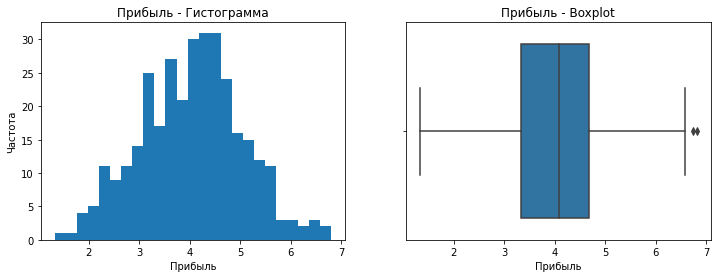

count    329.000000
mean       4.042948
std        1.006498
min        1.330000
25%        3.330000
50%        4.080000
75%        4.670000
max        6.810000
Name: Прибыль, dtype: float64


In [65]:
visualize_dataframe(market_tovary_dla_detei)

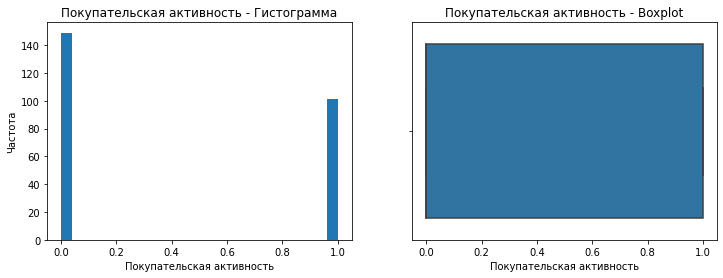

count    250.000000
mean       0.404000
std        0.491682
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Покупательская активность, dtype: float64


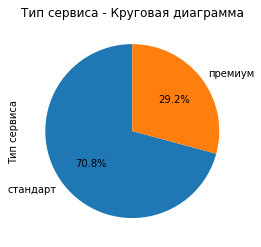

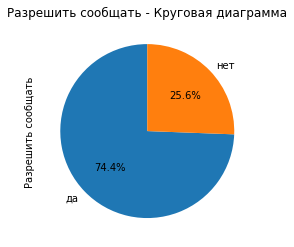

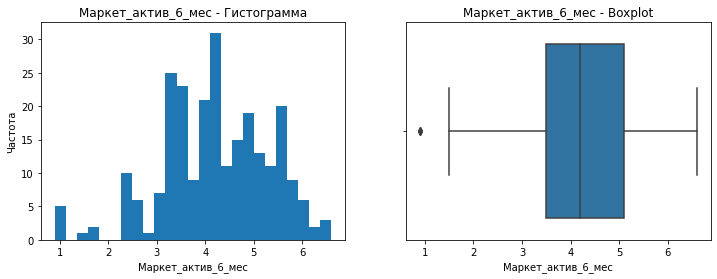

count    250.0000
mean       4.2108
std        1.1155
min        0.9000
25%        3.5000
50%        4.2000
75%        5.1000
max        6.6000
Name: Маркет_актив_6_мес, dtype: float64


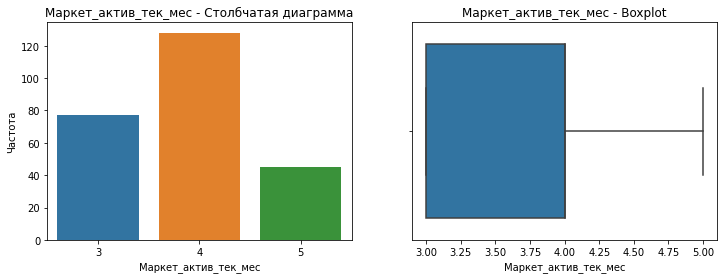

count    250.000000
mean       3.872000
std        0.688121
min        3.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Маркет_актив_тек_мес, dtype: float64


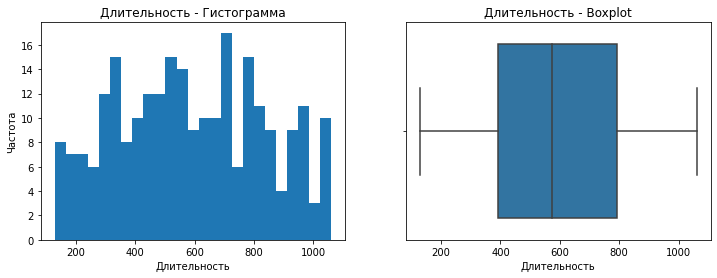

count     250.000000
mean      589.056000
std       247.546265
min       129.000000
25%       390.500000
50%       574.000000
75%       791.250000
max      1061.000000
Name: Длительность, dtype: float64


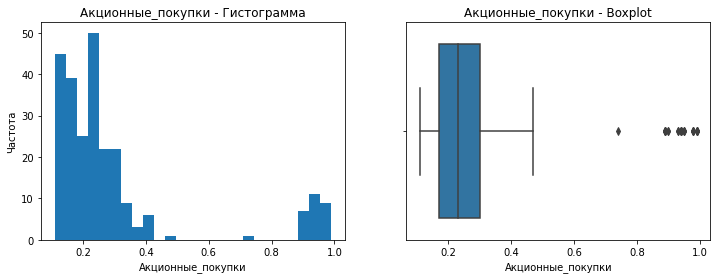

count    250.00000
mean       0.30056
std        0.23720
min        0.11000
25%        0.17000
50%        0.23000
75%        0.30000
max        0.99000
Name: Акционные_покупки, dtype: float64


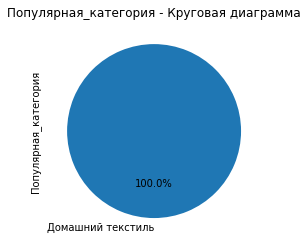

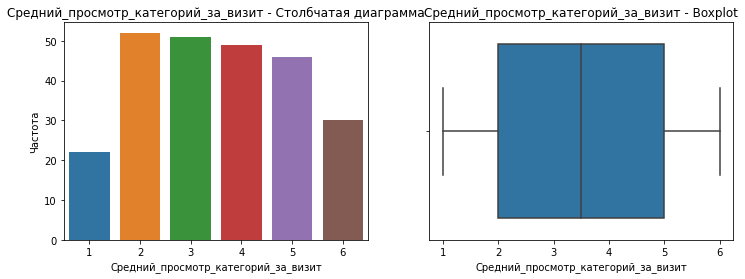

count    250.000000
mean       3.540000
std        1.513129
min        1.000000
25%        2.000000
50%        3.500000
75%        5.000000
max        6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64


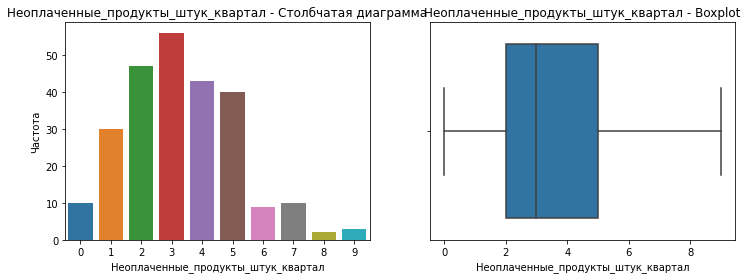

count    250.000000
mean       3.324000
std        1.828771
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        9.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64


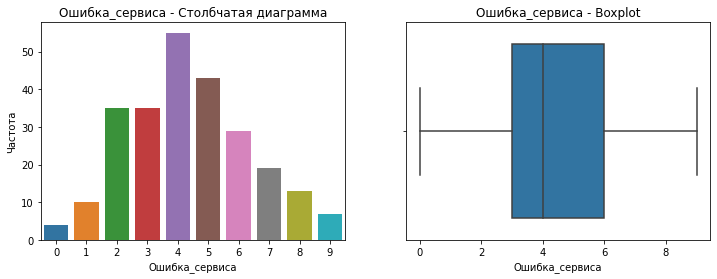

count    250.00000
mean       4.37600
std        2.01067
min        0.00000
25%        3.00000
50%        4.00000
75%        6.00000
max        9.00000
Name: Ошибка_сервиса, dtype: float64


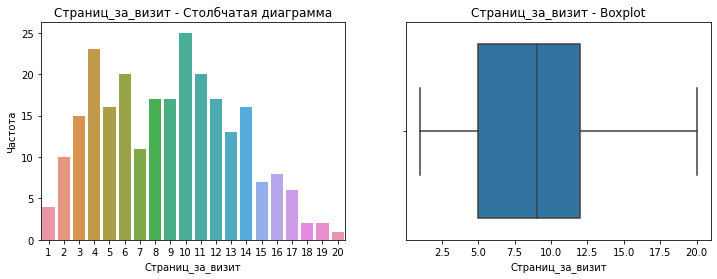

count    250.000000
mean       8.892000
std        4.359398
min        1.000000
25%        5.000000
50%        9.000000
75%       12.000000
max       20.000000
Name: Страниц_за_визит, dtype: float64


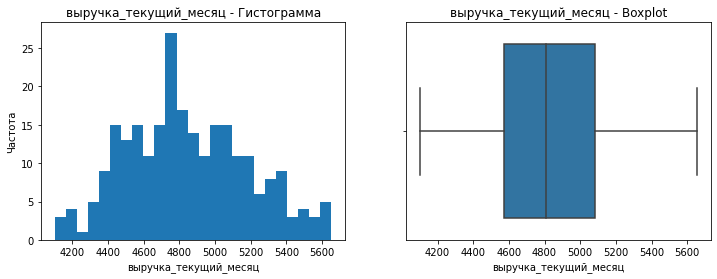

count     250.000000
mean     4847.060000
std       341.805977
min      4102.000000
25%      4573.500000
50%      4809.000000
75%      5085.250000
max      5653.000000
Name: выручка_текущий_месяц, dtype: float64


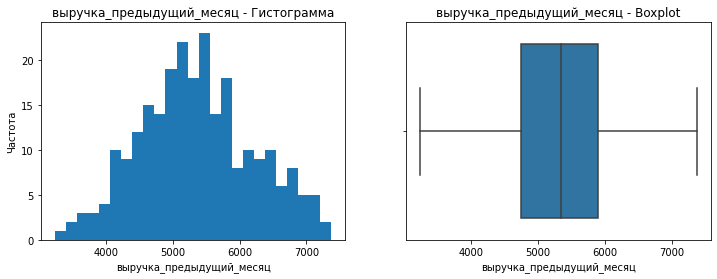

count     250.000000
mean     5365.237600
std       850.942955
min      3232.200000
25%      4750.650000
50%      5347.400000
75%      5899.725000
max      7374.000000
Name: выручка_предыдущий_месяц, dtype: float64


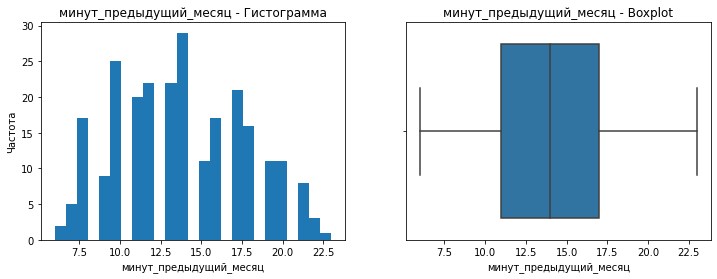

count    250.000000
mean      13.832000
std        3.882276
min        6.000000
25%       11.000000
50%       14.000000
75%       17.000000
max       23.000000
Name: минут_предыдущий_месяц, dtype: float64


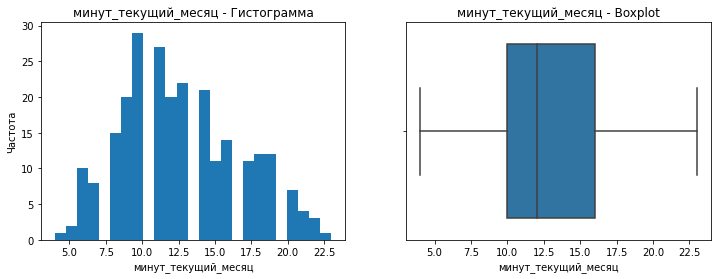

count    250.000000
mean      12.680000
std        4.051079
min        4.000000
25%       10.000000
50%       12.000000
75%       16.000000
max       23.000000
Name: минут_текущий_месяц, dtype: float64


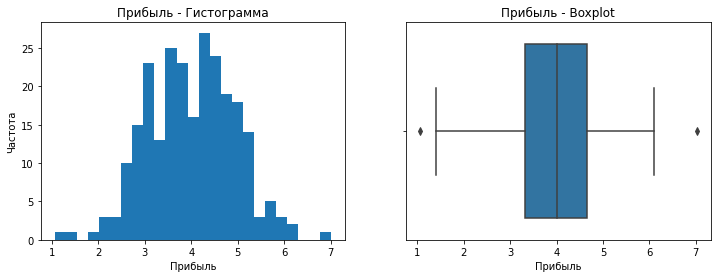

count    250.000000
mean       4.011960
std        0.932049
min        1.060000
25%        3.320000
50%        4.020000
75%        4.667500
max        7.020000
Name: Прибыль, dtype: float64


In [66]:
visualize_dataframe(market_domashniy_tekstil)

Мы видим, что покупательская способность у обоих сегментов чаще снижается, чем у всей выборки(по всей выборке 62% - прежний уровень, 38% - снизилась), надо учитывать, что это еще и самые большие две выборки при сегментации по типу самого популярного товара, которые в сумме составляют 45% всей выборки, это значит, в первую очередь работать над увеличением покупательской активности надо работать именно из этих сегментов При этом можем обратить внимание на то, что средняя прибыль по этим категориям примерна равна 4000, тогда как по всей выборке - примерно 5000, что укаывает на то, что при увеличении покупательской активнсоти может увеличиться и прибыль, что выгодно для магазина

Увеличение покупательной активности в онлайн-магазине, особенно в категории "Товары для детей", может быть достигнуто различными способами. Вот несколько идей:

Сезонные распродажи и специальные предложения: Проведение сезонных распродаж, например, перед началом учебного года, перед праздниками или во время межсезонных периодов, может стимулировать покупательскую активность. Бонусы и программы лояльности: Введение программ лояльности с бонусами за покупки или скидками для постоянных клиентов может стимулировать повторные покупки.

Контент-маркетинг: Создание интересного и полезного контента для целевой аудитории, такого как статьи о воспитании детей, игры и конкурсы, может привлечь внимание и увеличить лояльность клиентов.

Социальные медиа акции и конкурсы: Проведение акций и конкурсов в социальных сетях, где победителям предоставляются призы или скидки на покупки, может привлечь новых клиентов и удержать существующих.

Увеличение покупательной активности в онлайн-магазине, где основной категорией товаров является "Домашний текстиль", требует специфических подходов. Вот несколько идей:

Сезонные и тематические акции: Проведение сезонных и тематических акций, связанных с сезоном (например, летние скидки, зимние распродажи) или праздниками (Новый год, День матери и т. д.), может стимулировать покупательскую активность.

Пакетные предложения и скидки: Предложение скидок или специальных цен на пакеты товаров, например, комплекты постельного белья, наборы полотенец и т. д., может стимулировать клиентов к покупке большего количества товаров.

## Шаг 9.Общий вывод

Описание задачи: Перед нами стояла задача по разработке решения, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. В нашем рапроряжении было 4 таблицы с данными, первая о поведении покупателя на сайте, о коммуникациях с покупателями и его продуктововм поведении, следующая таблица включала данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом, таблица с данными о времени, которое покуптель провел на сайте и таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца.

Шаги решения и описание модели: На шаге предобработки мы сделали проверку на явные и неявные дубликаты, обработали пропуски, а также провели проверку типов данных в каждом столбце

Далее мы провели исследовательский анализ и объеденили таблицы, провели корреляционный анализ и начали строить пайплайн. Мы обучили 4 модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(), для каждой из них подобрали как минимум один гиперпараметр и выбрали метрику roc-auc как подходящую для задачи. Лучшей моделью оказалась модель SVC(C=1, probability=True, random_state=97) с результатом - Метрика ROC-AUC на тестовой выборке: 0.885652383245065

Далее мы оценили Важность признаков для определенной модели и построили график важности с помощью метода SHAP, сделали выводы о значимости признаков:

''' Последний график показывает показывает общую значимость признаков, здесь лидирует признак 'Страниц за визит', дальше идут такие признаки как 'минут_предыдущий_месяц' и 'Акционные_покупки'. Признаки на графике расположены в порядке убывания их вклада: если убрать те, что наверху, качество модели просядет сильнее всего. Теперь обратим внимание на график, который мы построили первым, он показывает как признаки влияют на предсказание модели. Высокое значение параметров 'страниц за визит' и 'минут предыдущий месяц' снижает вероятность принадлежности Покупательской активности клиента к классу 'Прежний уровень', что объяснить логически давольно сложно. Зато третий по значимости признак интерпритируется логически просто, высокие значение параметра 'акционные покупки' повышает вероятность принадлжености Покупательской активности клинета к классу 'Прежний уровень' '''

Описание этапа сегментации:После чего мы приступили к сегментации покуптелей и выделили 2 категории с которыми, по нашему мнению, стоит отдельно работать Интернет-магазину 'В один клик', это люди, которые больше всего покупают товары вида 'Домашний текстиль' и 'Товары для детей', предложили несколько мероприятий, которые могут помочь магазину увелечить покупательскую активность и в последствии прибыль для этих двух сегментов.

Рекомендации для магазина 'В один клик':

''' Увеличение покупательной активности в онлайн-магазине, особенно в категории "Товары для детей", может быть достигнуто различными способами. Вот несколько идей:

Сезонные распродажи и специальные предложения: Проведение сезонных распродаж, например, перед началом учебного года, перед праздниками или во время межсезонных периодов, может стимулировать покупательскую активность. Бонусы и программы лояльности: Введение программ лояльности с бонусами за покупки или скидками для постоянных клиентов может стимулировать повторные покупки.

Контент-маркетинг: Создание интересного и полезного контента для целевой аудитории, такого как статьи о воспитании детей, игры и конкурсы, может привлечь внимание и увеличить лояльность клиентов.

Социальные медиа акции и конкурсы: Проведение акций и конкурсов в социальных сетях, где победителям предоставляются призы или скидки на покупки, может привлечь новых клиентов и удержать существующих.

Увеличение покупательной активности в онлайн-магазине, где основной категорией товаров является "Домашний текстиль", требует специфических подходов. Вот несколько идей:

Сезонные и тематические акции: Проведение сезонных и тематических акций, связанных с сезоном (например, летние скидки, зимние распродажи) или праздниками (Новый год, День матери и т. д.), может стимулировать покупательскую активность.

Пакетные предложения и скидки: Предложение скидок или специальных цен на пакеты товаров, например, комплекты постельного белья, наборы полотенец и т. д., может стимулировать клиентов к покупке большего количества товаров.'''